## Analysis of Copernicus Satellite Data


### 1. Setup

_Install additional packages_

In [1]:
# Only uncomment if you are running notebook using Docker image
import os; os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

In [ ]:
%pip install -q lxml
%pip install -q pydap
%pip install -q python-dotenv
%pip install -q rasterstats
%pip install -q rioxarray
%pip install -q xarray
%pip install -q "xarray[io]"
%pip install -q cartopy

_Import libraries_

In [3]:
import geopandas as gpd
import lxml
import numpy as np
import os
import pandas as pd
import shutil
import requests
import rioxarray
import xarray
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cartopy.crs as ccrs
import folium
import matplotlib.pyplot as plt

from scripts import system_codes
from datetime import datetime, time, timedelta
from dotenv import load_dotenv
from pydap.cas.get_cookies import setup_session
from pydap.client import open_dods, open_file
from rasterstats import zonal_stats


_Load environment variables_

In [4]:
load_dotenv()

True

### 2. Data Preparation

In [6]:
# Load BOG buoys from file
buoys_df = pd.read_csv("data/buoys.tsv", delimiter='\t')
buoys_df.head()

,sensor_id,datetime,latitude,longitude,acceleration_mean,acceleration_q3,battery_soc,cloud_battery_soc,depth_mean,depth_q3,...,fast_update,last_updated,long_life,momsn,next_update,position_delta,speed,system_status,water_temperature_mean,water_temperature_q3
0,103,2021-03-25 18:01:08,37.471260,-121.940110,0.044290,0.085678,100.0,100.0,0.0,0.0,...,NaN,NaN,NaN,0,120,0.0,1.09,1557.0,23.0,23.0
1,103,2021-03-25 18:05:25,37.471252,-121.940216,0.070422,0.121168,100.0,100.0,0.0,0.0,...,NaN,NaN,NaN,1,120,0.0,0.00,33554960.0,23.0,23.0
2,103,2021-03-26 00:15:04,37.471207,-121.940300,0.375599,0.868697,100.0,100.0,0.0,0.0,...,NaN,NaN,NaN,2,120,0.0,0.36,34325.0,23.0,23.0
3,103,2021-03-26 00:19:13,37.471207,-121.940300,0.073840,0.143368,100.0,100.0,0.0,0.0,...,NaN,NaN,NaN,3,120,0.0,0.00,33296.0,24.0,24.0
4,103,2021-04-01 17:43:23,37.471222,-121.940600,0.041170,0.121168,92.0,100.0,0.0,0.0,...,NaN,NaN,NaN,4,120,0.0,0.08,34325.0,25.0,25.0


In [34]:
# Read buoys into GeoDataFrame
# NOTE: Buoy positions are given by lat/lon coordinates, which
# corresponds to a coordinate reference system (CRS) called EPSG:4326.
buoys_gdf = gpd.GeoDataFrame(
    buoys_df, 
    geometry=gpd.points_from_xy(
        x=buoys_df['longitude'],
        y=buoys_df['latitude'],
        crs="EPSG:4326"))
buoys_gdf.head()

,sensor_id,datetime,latitude,longitude,acceleration_mean,acceleration_q3,battery_soc,cloud_battery_soc,depth_mean,depth_q3,...,long_life,momsn,next_update,position_delta,speed,system_status,water_temperature_mean,water_temperature_q3,report_datetime,geometry
0,103,2021-03-25 18:01:08,37.471260,-121.940110,0.044290,0.085678,100.0,100.0,0.0,0.0,...,NaN,0,120,0.0,1.09,1557.0,23.0,23.0,2021-03-25 18:01:08,POINT (-121.94011 37.47126)
1,103,2021-03-25 18:05:25,37.471252,-121.940216,0.070422,0.121168,100.0,100.0,0.0,0.0,...,NaN,1,120,0.0,0.00,33554960.0,23.0,23.0,2021-03-25 18:05:25,POINT (-121.94022 37.47125)
2,103,2021-03-26 00:15:04,37.471207,-121.940300,0.375599,0.868697,100.0,100.0,0.0,0.0,...,NaN,2,120,0.0,0.36,34325.0,23.0,23.0,2021-03-26 00:15:04,POINT (-121.94030 37.47121)
3,103,2021-03-26 00:19:13,37.471207,-121.940300,0.073840,0.143368,100.0,100.0,0.0,0.0,...,NaN,3,120,0.0,0.00,33296.0,24.0,24.0,2021-03-26 00:19:13,POINT (-121.94030 37.47121)
4,103,2021-04-01 17:43:23,37.471222,-121.940600,0.041170,0.121168,92.0,100.0,0.0,0.0,...,NaN,4,120,0.0,0.08,34325.0,25.0,25.0,2021-04-01 17:43:23,POINT (-121.94060 37.47122)


In [35]:
# Create buffers/circles around buoys 
buoys_gdf['buffer'] = (buoys_gdf
    .to_crs("ESRI:102009")
    .buffer(1)
    .to_crs("EPSG:4326"))
buoys_gdf.head()

,sensor_id,datetime,latitude,longitude,acceleration_mean,acceleration_q3,battery_soc,cloud_battery_soc,depth_mean,depth_q3,...,momsn,next_update,position_delta,speed,system_status,water_temperature_mean,water_temperature_q3,report_datetime,geometry,buffer
0,103,2021-03-25 18:01:08,37.471260,-121.940110,0.044290,0.085678,100.0,100.0,0.0,0.0,...,0,120,0.0,1.09,1557.0,23.0,23.0,2021-03-25 18:01:08,POINT (-121.94011 37.47126),"POLYGON ((-121.94010 37.47126, -121.94010 37.4..."
1,103,2021-03-25 18:05:25,37.471252,-121.940216,0.070422,0.121168,100.0,100.0,0.0,0.0,...,1,120,0.0,0.00,33554960.0,23.0,23.0,2021-03-25 18:05:25,POINT (-121.94022 37.47125),"POLYGON ((-121.94020 37.47125, -121.94020 37.4..."
2,103,2021-03-26 00:15:04,37.471207,-121.940300,0.375599,0.868697,100.0,100.0,0.0,0.0,...,2,120,0.0,0.36,34325.0,23.0,23.0,2021-03-26 00:15:04,POINT (-121.94030 37.47121),"POLYGON ((-121.94029 37.47121, -121.94029 37.4..."
3,103,2021-03-26 00:19:13,37.471207,-121.940300,0.073840,0.143368,100.0,100.0,0.0,0.0,...,3,120,0.0,0.00,33296.0,24.0,24.0,2021-03-26 00:19:13,POINT (-121.94030 37.47121),"POLYGON ((-121.94029 37.47121, -121.94029 37.4..."
4,103,2021-04-01 17:43:23,37.471222,-121.940600,0.041170,0.121168,92.0,100.0,0.0,0.0,...,4,120,0.0,0.08,34325.0,25.0,25.0,2021-04-01 17:43:23,POINT (-121.94060 37.47122),"POLYGON ((-121.94059 37.47122, -121.94059 37.4..."


In [36]:
# Create new GeoDataFrame with buffer column as geometry
buoy_buffer_gdf = buoys_gdf.set_geometry('buffer', drop=True, inplace=False, crs="EPSG:4326")
buoy_buffer_gdf.head()

,sensor_id,datetime,latitude,longitude,acceleration_mean,acceleration_q3,battery_soc,cloud_battery_soc,depth_mean,depth_q3,...,long_life,momsn,next_update,position_delta,speed,system_status,water_temperature_mean,water_temperature_q3,report_datetime,geometry
0,103,2021-03-25 18:01:08,37.471260,-121.940110,0.044290,0.085678,100.0,100.0,0.0,0.0,...,NaN,0,120,0.0,1.09,1557.0,23.0,23.0,2021-03-25 18:01:08,"POLYGON ((-121.94010 37.47126, -121.94010 37.4..."
1,103,2021-03-25 18:05:25,37.471252,-121.940216,0.070422,0.121168,100.0,100.0,0.0,0.0,...,NaN,1,120,0.0,0.00,33554960.0,23.0,23.0,2021-03-25 18:05:25,"POLYGON ((-121.94020 37.47125, -121.94020 37.4..."
2,103,2021-03-26 00:15:04,37.471207,-121.940300,0.375599,0.868697,100.0,100.0,0.0,0.0,...,NaN,2,120,0.0,0.36,34325.0,23.0,23.0,2021-03-26 00:15:04,"POLYGON ((-121.94029 37.47121, -121.94029 37.4..."
3,103,2021-03-26 00:19:13,37.471207,-121.940300,0.073840,0.143368,100.0,100.0,0.0,0.0,...,NaN,3,120,0.0,0.00,33296.0,24.0,24.0,2021-03-26 00:19:13,"POLYGON ((-121.94029 37.47121, -121.94029 37.4..."
4,103,2021-04-01 17:43:23,37.471222,-121.940600,0.041170,0.121168,92.0,100.0,0.0,0.0,...,NaN,4,120,0.0,0.08,34325.0,25.0,25.0,2021-04-01 17:43:23,"POLYGON ((-121.94059 37.47122, -121.94059 37.4..."


In [37]:
# Subset to desired columns
cols_to_keep = [
    'sensor_id',
    'datetime',
    'latitude',
    'longitude',
    'water_temperature_mean',
    'water_temperature_q3',
    'geometry' 
]
buoy_buffer_gdf = buoy_buffer_gdf[cols_to_keep]
buoy_buffer_gdf

,sensor_id,datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry
0,103,2021-03-25 18:01:08,37.471260,-121.940110,23.0,23.0,"POLYGON ((-121.94010 37.47126, -121.94010 37.4..."
1,103,2021-03-25 18:05:25,37.471252,-121.940216,23.0,23.0,"POLYGON ((-121.94020 37.47125, -121.94020 37.4..."
2,103,2021-03-26 00:15:04,37.471207,-121.940300,23.0,23.0,"POLYGON ((-121.94029 37.47121, -121.94029 37.4..."
3,103,2021-03-26 00:19:13,37.471207,-121.940300,24.0,24.0,"POLYGON ((-121.94029 37.47121, -121.94029 37.4..."
4,103,2021-04-01 17:43:23,37.471222,-121.940600,25.0,25.0,"POLYGON ((-121.94059 37.47122, -121.94059 37.4..."
...,...,...,...,...,...,...,...
31393,590,2022-09-30 11:52:26,44.101097,-68.073380,13.0,14.0,"POLYGON ((-68.07337 44.10109, -68.07337 44.101..."
31394,590,2022-10-01 11:52:26,44.101190,-68.073746,13.0,14.0,"POLYGON ((-68.07373 44.10119, -68.07373 44.101..."
31395,590,2022-10-02 12:02:00,44.101370,-68.074280,12.0,13.0,"POLYGON ((-68.07427 44.10137, -68.07427 44.101..."
31396,590,2022-10-03 12:10:06,44.101050,-68.073580,12.0,12.0,"POLYGON ((-68.07357 44.10105, -68.07357 44.101..."


In [39]:
# Remove "bad" records
buoy_buffer_gdf = buoy_buffer_gdf[(buoy_buffer_gdf['latitude']< 52)  & (buoy_buffer_gdf['latitude']> 37)]
buoy_buffer_gdf = buoy_buffer_gdf[(buoy_buffer_gdf['longitude']< -51)  & (buoy_buffer_gdf['longitude']> -73)]
buoy_buffer_gdf.head()

,sensor_id,datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry
15,103,2022-04-13 21:23:06,47.484776,-63.311108,2.0,2.0,"POLYGON ((-63.31109 47.48477, -63.31110 47.484..."
16,103,2022-04-13 22:23:36,47.484440,-63.311733,3.0,4.0,"POLYGON ((-63.31172 47.48444, -63.31172 47.484..."
17,103,2022-04-13 23:23:36,47.484764,-63.311810,0.0,4.0,"POLYGON ((-63.31180 47.48476, -63.31180 47.484..."
18,103,2022-04-14 00:23:36,47.484920,-63.311733,-1.0,4.0,"POLYGON ((-63.31172 47.48492, -63.31172 47.484..."
19,103,2022-04-14 01:23:36,47.485010,-63.311676,-1.0,4.0,"POLYGON ((-63.31166 47.48501, -63.31166 47.485..."


### 3. Data Retrieval

In [338]:
# Retrieve username and password from environment variables
try:
    username = os.environ['COPERNICUS_USERNAME']
    password = os.environ['COPERNICUS_PASSWORD']
except KeyError as e:
    raise Exception(f"Missing environment variable {e}.")

In [339]:
# Authenticate against server using username and password to generate cookies
cas_url = 'https://cmems-cas.cls.fr/cas/login'
session = setup_session(cas_url, username, password)
cookies = {"CASTGC": session.cookies.get_dict()['CASTGC']}

In [340]:
# Generate date range to process data
buoy_buffer_gdf['datetime'] = pd.to_datetime(buoys_df['datetime'])
buoy_buffer_gdf.rename(columns={'datetime':'report_datetime'}, inplace=True)

offset = timedelta(minutes=30)
start_date = datetime.combine(buoy_buffer_gdf['report_datetime'].min(), time.min) - offset
end_date = datetime.combine(buoy_buffer_gdf['report_datetime'].max(), time.min) + offset
print(f"Will process dates between {start_date.strftime('%Y-%m-%d')} and {end_date.strftime('%Y-%m-%d')}, inclusive.")

Will process dates between 2022-04-11 and 2022-10-04, inclusive.


A total of 4201 hours 

In [ ]:
# Retrieve one hour of data at a time
final_df = None
buoy_hours_diff = int((end_date - start_date).total_seconds() / 3600)

try:
    for i in range(buoy_hours_diff):
        # Define start and end dates for querying data in this iteration of the for-loop
        data_start = start_date + timedelta(hours=i)
        data_end = data_start + timedelta(hours=1)
        print(i, data_start, "to", data_end)

        # Check to see if any buoy messages were reported during hour
        batch_gdf = buoy_buffer_gdf.query('`report_datetime` >= @data_start & `report_datetime` < @data_end')
        if not len(batch_gdf):
            continue
        # display(batch_gdf.head())

        # If there are, generate query URL using variable, date range
        dods_server_url = "https://nrt.cmems-du.eu/thredds/dodsC"
        dataset = "global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh"
        extension = "dods"
        base_url = f'{dods_server_url}/{dataset}.{extension}'

        # The Copernicus date field can be understood as hours since the minimum
        # value (i.e., 2020-01-01 00:30:00Z), which has an index of zero.
        cop_data_start = datetime.strptime("2020-01-01 00:30:00", '%Y-%m-%d %H:%M:%S')
        cop_diff = data_start - cop_data_start
        cop_hours_since_start = int(cop_diff.total_seconds() / 3600)

        # If there are, generate query URL using variable, date range
        variable = "thetao"
        time_constraint = f'[{cop_hours_since_start}:1:{cop_hours_since_start}]'
        depth_constraint = "[0:1:0]" # Only one depth available in dataset
        lat_constraint = "[1200:1:1680]"
        lon_constraint = "[1260:1:1740]"
        query = f"longitude{lon_constraint},latitude{lat_constraint}," + \
            f"depth{depth_constraint},time{time_constraint},{variable}" + \
            f"{time_constraint}{depth_constraint}{lat_constraint}{lon_constraint}"

        # Create final dataset URL
        dataset_url = f'{base_url}?{query}'
        # print(dataset_url)

        # Make request against server, reading response into temp file
        tmp_nc_file_name = "temp.nc"
        with requests.get(dataset_url, cookies=cookies, stream=True) as r:
            r.raise_for_status()
            with open(tmp_nc_file_name, 'wb') as f:
                shutil.copyfileobj(r.raw, f)

        # Read data into xarray for easier manipulation
        pydap_dataset = open_file(tmp_nc_file_name)
        store = xarray.backends.PydapDataStore(pydap_dataset)
        ds = xarray.open_dataset(store)
        # display(ds)
    
        # Write temporary TIF file from variable
        coper_var = ds.data_vars[variable]
        missing_value = -32767
        tmp_tif_file_name = "temp_variable.tif"
        coper_var.rio.write_nodata(missing_value, inplace=True)
        coper_var.rio.write_crs(4326, inplace=True)
        coper_var.isel(time=0).isel(depth=0).rio.to_raster(tmp_tif_file_name)
        
        # Generate zonal statistics (i.e., for temperature in buffer zones around messages)
        # NOTE: If the `coper_var` isnt' accepted, you can convert it to 
        # a .tif file and then send the file path in:
        # 
        # Example:
        # coper_var.rio.to_raster("variable.tif")
        # zonal_stats(buoy_buffer_gdf, "variable.tif")
        #
        # Reference:
        # https://pythonhosted.org/rasterstats/manual.html#introduction
        #
        stats = zonal_stats(
            batch_gdf,
            tmp_tif_file_name,
            stats=['min', 'max', 'mean', 'median', 'count'],
            all_touched=True)

        # Save stats as dataFrame 
        # The result of "zonal_stats" looks something like:
        # [{'min': 75, 'max': 14.660084635416666, ...}, {'min': 50, 'max': 56.605761718750003, ...}]
        #
        # Results presumably come back in the order that the buffers were in.
        #
        stats_df = pd.DataFrame(stats)
        # print(stats_df)

        # Join with buffer DataFrame
        combined_df = batch_gdf.reset_index().join(stats_df)

        # Update final DataFrame
        # NOTE: You may have to select only a subset of columns to save memory.
        final_df = combined_df if final_df is None else pd.concat([final_df, combined_df])
        # print(f"There are {len(final_df)} row(s) in the final DataFrame.")

        # Remove any temp files created during for-loop
        os.remove(tmp_nc_file_name)
        os.remove(tmp_tif_file_name)
        
        # Process results
        if final_df is not None:
            
            # Write final results to CSV file
            final_df.drop(columns="index").to_csv("buffered_11.csv", index=False)
             
except Exception as e:
    print(e)
    try:
        os.remove(tmp_nc_file_name)
    except:
        pass
    
    try:
        os.remove(tmp_tif_file_name)
    except:
        pass


### 4. Data preprocessing

In [6]:
# Combine all csv files together 
df = pd.concat(
    map(pd.read_csv, ['buffered.csv', 'buffered_2.csv',
                      'buffered_3.csv','buffered_4.csv',
                      'buffered_5.csv','buffered_6.csv',
                     'buffered_7.csv','buffered_8.csv',
                     'buffered_9.csv','buffered_10.csv'
                     ]), ignore_index=True)

# df.to_csv('final_combined_buffered.csv', index = False)

# Load data
df = pd.read_csv('final_combined_buffered.csv') # 29278 rows × 12 columns
df.tail()

,sensor_id,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean,median,count
29273,588,2022-10-02 16:57:18,44.093990,-68.102840,12.0,12.0,POLYGON ((-68.10282739751055 44.09398699107489...,-9189.0,-9189.0,-9189.0,-9189.0,1
29274,590,2022-10-03 12:10:06,44.101050,-68.073580,12.0,12.0,POLYGON ((-68.07356739749643 44.10104698805128...,-9591.0,-9591.0,-9591.0,-9591.0,1
29275,589,2022-10-03 13:37:00,44.013313,-68.092995,12.0,12.0,POLYGON ((-68.09298241413764 44.01330998978174...,-9467.0,-9467.0,-9467.0,-9467.0,1
29276,587,2022-10-03 15:26:08,43.981586,-68.078440,12.0,12.0,POLYGON ((-68.07842742117528 43.98158298816211...,-9466.0,-9466.0,-9466.0,-9466.0,1
29277,588,2022-10-03 17:06:37,44.093610,-68.103020,12.0,12.0,POLYGON ((-68.10300739757815 44.09360699109235...,-9552.0,-9552.0,-9552.0,-9552.0,1


In [24]:
# Drop missing values (i.e., count = 0)
cop_data = df[df['count'] != 0].reset_index(drop=True) # 29242 rows × 12 columns
cop_data.head()


,sensor_id,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean,median,count
0,104,2022-04-13 17:48:06,47.698048,-63.222088,4.0,4.000000e+00,POLYGON ((-63.222074897369176 47.6980445092285...,-28594.0,-28594.0,-28594.0,-28594.0,1
1,109,2022-04-13 17:53:06,47.695377,-63.224490,7.0,7.000000e+00,"POLYGON ((-63.2244768978212 47.6953735094507, ...",-28594.0,-28594.0,-28594.0,-28594.0,1
2,111,2022-04-13 18:07:24,47.673440,-63.244347,3.0,3.000000e+00,POLYGON ((-63.24433390152473 47.67343651128858...,-28594.0,-28594.0,-28594.0,-28594.0,1
3,124,2022-04-13 17:42:36,47.701230,-63.219093,4.0,4.000000e+00,POLYGON ((-63.219079896838515 47.7012265089504...,-28594.0,-28594.0,-28594.0,-28594.0,1
4,461,2022-04-13 18:12:46,47.675390,-63.242210,0.0,1.175494e-38,POLYGON ((-63.24219690121765 47.67538651108744...,-28594.0,-28594.0,-28594.0,-28594.0,1


In [25]:
# Scale fields (temperature)
temp_scale_factor = 7.324442267417908 * 10**-4
temp_offset = 21.0
temp_stat_cols = ['min', 'max', 'mean', 'median']
for col in temp_stat_cols:
    cop_data[col] = cop_data[col].apply(lambda val: (val * temp_scale_factor) + temp_offset)
    

In [26]:
# Change the column name "mean" to "mean_temp"
cop_data = cop_data.rename({'mean': 'mean_temp'}, axis=1)

In [19]:
cop_data.tail()

,sensor_id,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean_temp,median,count
29237,588,2022-10-02 16:57:18,44.093990,-68.102840,12.0,12.0,POLYGON ((-68.10282739751055 44.09398699107489...,14.269570,14.269570,14.269570,14.269570,1
29238,590,2022-10-03 12:10:06,44.101050,-68.073580,12.0,12.0,POLYGON ((-68.07356739749643 44.10104698805128...,13.975127,13.975127,13.975127,13.975127,1
29239,589,2022-10-03 13:37:00,44.013313,-68.092995,12.0,12.0,POLYGON ((-68.09298241413764 44.01330998978174...,14.065951,14.065951,14.065951,14.065951,1
29240,587,2022-10-03 15:26:08,43.981586,-68.078440,12.0,12.0,POLYGON ((-68.07842742117528 43.98158298816211...,14.066683,14.066683,14.066683,14.066683,1
29241,588,2022-10-03 17:06:37,44.093610,-68.103020,12.0,12.0,POLYGON ((-68.10300739757815 44.09360699109235...,14.003693,14.003693,14.003693,14.003693,1


In [27]:
# Preview buoy fishery assignments
buoy_fishery_df = pd.read_csv("data/buoy_fishery_assignments.tsv", delimiter='\t')
buoy_fishery_df.head()

,buoy_id,fishery_id
0,103,3
1,104,3
2,105,3
3,106,3
4,107,3


In [9]:
# Load BOG buoys from file
buoys_df = pd.read_csv("data/buoys.tsv", delimiter='\t')
buoys_df.head(1)

,sensor_id,datetime,latitude,longitude,acceleration_mean,acceleration_q3,battery_soc,cloud_battery_soc,depth_mean,depth_q3,...,fast_update,last_updated,long_life,momsn,next_update,position_delta,speed,system_status,water_temperature_mean,water_temperature_q3
0,103,2021-03-25 18:01:08,37.47126,-121.94011,0.04429,0.085678,100.0,100.0,0.0,0.0,...,NaN,NaN,NaN,0,120,0.0,1.09,1557.0,23.0,23.0


In [29]:
# Merge buoy_df and buoy_fisheries_assignment dataframes
merged_cop_fish = pd.merge(cop_data, buoy_fishery_df, 
                          left_on = 'sensor_id', 
                          right_on = 'buoy_id')
merged_cop_fish.head()

,sensor_id,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean_temp,median,count,buoy_id,fishery_id
0,104,2022-04-13 17:48:06,47.698048,-63.222088,4.0,4.0,POLYGON ((-63.222074897369176 47.6980445092285...,0.056490,0.056490,0.056490,0.056490,1,104,3
1,104,2022-04-13 19:51:36,47.697420,-63.221302,7.0,7.0,POLYGON ((-63.221288897555546 47.6974165091437...,0.290872,0.290872,0.290872,0.290872,1,104,3
2,104,2022-04-14 19:51:36,47.696667,-63.221010,11.0,19.0,POLYGON ((-63.22099689774044 47.69666350910806...,0.842402,0.842402,0.842402,0.842402,1,104,3
3,104,2022-04-15 19:53:36,47.697063,-63.222130,2.0,10.0,"POLYGON ((-63.2221168975859 47.69705950922489,...",0.052095,0.052095,0.052095,0.052095,1,104,3
4,104,2022-04-16 19:55:36,47.696415,-63.221260,2.0,4.0,POLYGON ((-63.22124689778171 47.69641150913143...,-0.040925,-0.040925,-0.040925,-0.040925,1,104,3


In [30]:
# Merge the "system_status" column to the merged_cop_fish
buoys_df['report_datetime']= buoys_df['datetime']
merged_cop_fish = pd.merge(merged_cop_fish, buoys_df[['report_datetime','system_status', 'sensor_id']],on=['report_datetime', 'sensor_id'], how='left')
merged_cop_fish = merged_cop_fish.drop_duplicates().reset_index(drop = True)
merged_cop_fish.drop(['sensor_id'],axis = 1, inplace = True)
merged_cop_fish.head() # 29242 rows × 14 columns

,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean_temp,median,count,buoy_id,fishery_id,system_status
0,2022-04-13 17:48:06,47.698048,-63.222088,4.0,4.0,POLYGON ((-63.222074897369176 47.6980445092285...,0.056490,0.056490,0.056490,0.056490,1,104,3,1557.0
1,2022-04-13 19:51:36,47.697420,-63.221302,7.0,7.0,POLYGON ((-63.221288897555546 47.6974165091437...,0.290872,0.290872,0.290872,0.290872,1,104,3,1045.0
2,2022-04-14 19:51:36,47.696667,-63.221010,11.0,19.0,POLYGON ((-63.22099689774044 47.69666350910806...,0.842402,0.842402,0.842402,0.842402,1,104,3,1045.0
3,2022-04-15 19:53:36,47.697063,-63.222130,2.0,10.0,"POLYGON ((-63.2221168975859 47.69705950922489,...",0.052095,0.052095,0.052095,0.052095,1,104,3,1045.0
4,2022-04-16 19:55:36,47.696415,-63.221260,2.0,4.0,POLYGON ((-63.22124689778171 47.69641150913143...,-0.040925,-0.040925,-0.040925,-0.040925,1,104,3,1045.0


In [31]:
# Change report_datetime to datetime object and sort
merged_cop_fish['report_datetime'] = pd.to_datetime(merged_cop_fish['report_datetime'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
merged_cop_fish = merged_cop_fish.sort_values('report_datetime', ascending=True)
merged_cop_fish = merged_cop_fish.reset_index(drop = True)


### 5. Analyze Geography: Some facts about the North Atlantic Ocean

The bathymetry of lower bathyal is around 800-3500 m [1]. The average water temperature of the Northern Atlantic Coast is between 34.2°C and 77.7°F [2]. The tidal range of the Atlantic Ocean is 2 to 3 feet [3].

Sources:

[1] https://www.researchgate.net/figure/Bathymetry-map-of-the-North-Atlantic-Ocean-based-on-the-GEBCO-30-grid-showing-the_fig1_258385100

[2] https://www.ncei.noaa.gov/access/coastal-water-temperature-guide/natl.html

[3] https://www.britannica.com/place/Atlantic-Ocean/Tides

### 6. Visualize Copernicus temperature on a map
#### Visualize Copernicus Data.  Plot each variable (sea surface current direction and temperature) on top of a map at different timestamps to illustrate how the variable changes over time in the Northwest Atlantic.

In [341]:
# Process one hour at a time

try:
    for i in range(3970, 3994):
        # Define start and end dates for querying data in this iteration of the for-loop
        data_start = start_date + timedelta(hours=i)
        data_end = data_start + timedelta(hours=1)
        print(i, data_start, "to", data_end)

        # Check to see if any buoy messages were reported during hour
        batch_gdf = buoy_buffer_gdf.query('`report_datetime` >= @data_start & `report_datetime` < @data_end')
        if not len(batch_gdf):
            continue
        # display(batch_gdf.head())

        # If there are, generate query URL using variable, date range
        dods_server_url = "https://nrt.cmems-du.eu/thredds/dodsC"
        dataset = "global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh"
        extension = "dods"
        base_url = f'{dods_server_url}/{dataset}.{extension}'

        # The Copernicus date field can be understood as hours since the minimum
        # value (i.e., 2020-01-01 00:30:00Z), which has an index of zero.
        cop_data_start = datetime.strptime("2020-01-01 00:30:00", '%Y-%m-%d %H:%M:%S')
        cop_diff = data_start - cop_data_start
        cop_hours_since_start = int(cop_diff.total_seconds() / 3600)

        # If there are, generate query URL using variable, date range
        variable = "thetao"
        time_constraint = f'[{cop_hours_since_start}:1:{cop_hours_since_start}]'
        depth_constraint = "[0:1:0]" # Only one depth available in dataset
        lat_constraint = "[1200:1:1680]"
        lon_constraint = "[1260:1:1740]"
        query = f"longitude{lon_constraint},latitude{lat_constraint}," + \
            f"depth{depth_constraint},time{time_constraint},{variable}" + \
            f"{time_constraint}{depth_constraint}{lat_constraint}{lon_constraint}"

        # Create final dataset URL
        dataset_url = f'{base_url}?{query}'
        # print(dataset_url)

        # Make request against server, reading response into temp file
        tmp_nc_file_name = "temp.nc"
        with requests.get(dataset_url, cookies=cookies, stream=True) as r:
            r.raise_for_status()
            with open(tmp_nc_file_name, 'wb') as f:
                shutil.copyfileobj(r.raw, f)

        # Read data into xarray for easier manipulation
        pydap_dataset = open_file(tmp_nc_file_name)
        store = xarray.backends.PydapDataStore(pydap_dataset)
        ds_3 = xarray.open_dataset(store)
        # display(ds)
    
        # Write temporary TIF file from variable
        coper_var = ds.data_vars[variable]
        missing_value = -32767
        tmp_tif_file_name = "time3.tif"
        coper_var.rio.write_nodata(missing_value, inplace=True)
        coper_var.rio.write_crs(4326, inplace=True)
        coper_var.isel(time=0).isel(depth=0).rio.to_raster(tmp_tif_file_name)

except Exception as e:
    print(e)
    try:
        os.remove(tmp_nc_file_name)
    except:
        pass
    
    try:
        os.remove(tmp_tif_file_name)
    except:
        pass


3970 2022-09-24 09:30:00 to 2022-09-24 10:30:00
3971 2022-09-24 10:30:00 to 2022-09-24 11:30:00
3972 2022-09-24 11:30:00 to 2022-09-24 12:30:00
3973 2022-09-24 12:30:00 to 2022-09-24 13:30:00
3974 2022-09-24 13:30:00 to 2022-09-24 14:30:00
3975 2022-09-24 14:30:00 to 2022-09-24 15:30:00
3976 2022-09-24 15:30:00 to 2022-09-24 16:30:00
3977 2022-09-24 16:30:00 to 2022-09-24 17:30:00
3978 2022-09-24 17:30:00 to 2022-09-24 18:30:00
3979 2022-09-24 18:30:00 to 2022-09-24 19:30:00
3980 2022-09-24 19:30:00 to 2022-09-24 20:30:00
3981 2022-09-24 20:30:00 to 2022-09-24 21:30:00
3982 2022-09-24 21:30:00 to 2022-09-24 22:30:00
3983 2022-09-24 22:30:00 to 2022-09-24 23:30:00
3984 2022-09-24 23:30:00 to 2022-09-25 00:30:00
3985 2022-09-25 00:30:00 to 2022-09-25 01:30:00
3986 2022-09-25 01:30:00 to 2022-09-25 02:30:00
3987 2022-09-25 02:30:00 to 2022-09-25 03:30:00
3988 2022-09-25 03:30:00 to 2022-09-25 04:30:00
3989 2022-09-25 04:30:00 to 2022-09-25 05:30:00
3990 2022-09-25 05:30:00 to 2022-09-25 0

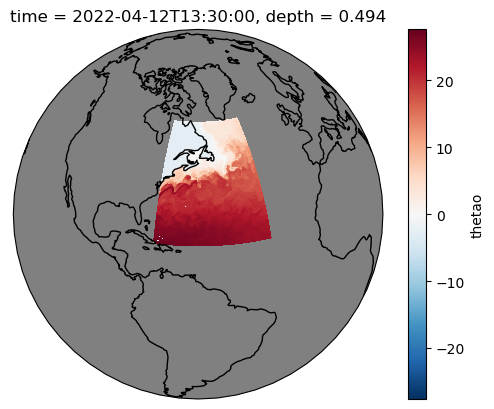

In [278]:
# Transform ds 
df = ds.to_dataframe()
df = df.reset_index() 

# Start date
start_date = "1950-01-01 00:30:00"
dt = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

# Create a new column to convert time (no. of hours) to datetime
df['time'] = dt + df.time.astype('timedelta64[h]')
# Scale fields (temperature)
temp_scale_factor = 7.324442267417908 * 10**-4
temp_offset = 21.0
df['thetao'] = df['thetao'].apply(lambda val: (val * temp_scale_factor) + temp_offset)

# Change index
df_multiindex = df.set_index(['time', 'depth','latitude','longitude'])
data = df_multiindex.to_xarray()

# Visualize "thetao" variable on map
thetao = data.data_vars["thetao"]
p = thetao.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-60, 30), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.set_global()
p.axes.coastlines()



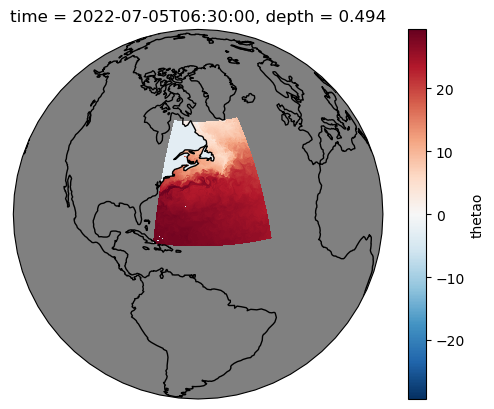

In [349]:
from matplotlib import colorbar, colors
# Transform ds 
df = ds_2.to_dataframe()
df = df.reset_index() 

# Start date
start_date = "1950-01-01 00:30:00"
dt = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

# Create a new column to convert time (no. of hours) to datetime
df['time'] = dt + df.time.astype('timedelta64[h]')
# Scale fields (temperature)
temp_scale_factor = 7.324442267417908 * 10**-4
temp_offset = 21.0
df['thetao'] = df['thetao'].apply(lambda val: (val * temp_scale_factor) + temp_offset)

# Change index
df_multiindex = df.set_index(['time', 'depth','latitude','longitude'])
data = df_multiindex.to_xarray()

# Visualize "thetao" variable on map
thetao = data.data_vars["thetao"]
p = thetao.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-60, 30), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.set_global()
p.axes.coastlines()



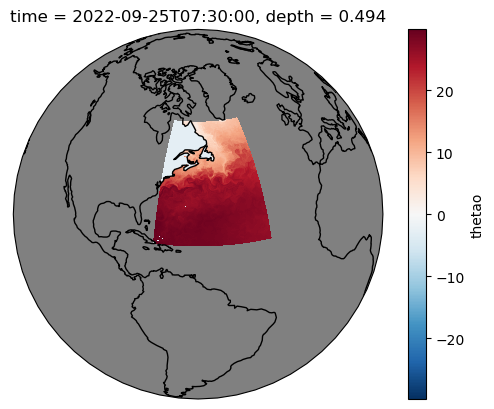

In [342]:
# Transform ds 
df = ds_3.to_dataframe()
df = df.reset_index() 

# Start date
start_date = "1950-01-01 00:30:00"
dt = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

# Create a new column to convert time (no. of hours) to datetime
df['time'] = dt + df.time.astype('timedelta64[h]')
# Scale fields (temperature)
temp_scale_factor = 7.324442267417908 * 10**-4
temp_offset = 21.0
df['thetao'] = df['thetao'].apply(lambda val: (val * temp_scale_factor) + temp_offset)

# Change index
df_multiindex = df.set_index(['time', 'depth','latitude','longitude'])
data = df_multiindex.to_xarray()

# Visualize "thetao" variable on map
thetao = data.data_vars["thetao"]
p = thetao.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-60, 30), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.set_global()
p.axes.coastlines()

### 7. Analyze Water Temperature differences by deployments
#### Segment the buoy messages into deployments based on their “Entered Water” and “Left Water" flags

In [27]:
# Segment the buoy messages into deployments based on their “Entered Water” and “Left Water'' flags
merged_cop_fish['system_status'] = merged_cop_fish['system_status'].fillna('Unknown')
merged_cop_fish['system_status_int'] = merged_cop_fish['system_status'].apply(lambda x : int(x) if x != 'Unknown' else 'Unknown')
merged_cop_fish['system_status_cat'] = merged_cop_fish['system_status_int'].apply(lambda x : system_codes.parse_system_flags(x) if x!= 'Unknown' else 'Unknown')
merged_cop_fish['system_status_interpret'] = merged_cop_fish['system_status_cat'].apply(lambda x:system_codes.human_readable_reason(x))
merged_cop_fish['system_status_interpret']

0        Entered Water
1        Entered Water
2        Entered Water
3        Entered Water
4        Entered Water
             ...      
29237            Moved
29238        Scheduled
29239        Scheduled
29240        Scheduled
29241        Scheduled
Name: system_status_interpret, Length: 29242, dtype: object

In [28]:
# Unique flags
merged_cop_fish['system_status_interpret'].unique()

array(['Entered Water', 'Scheduled', 'Moved', 'Left Water', 'Resurfaced'],
      dtype=object)

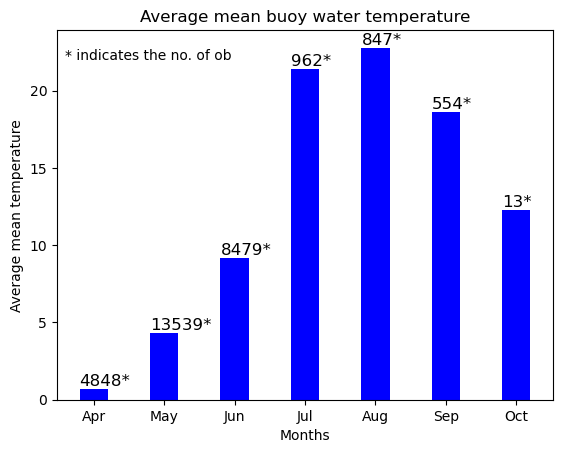

In [38]:
# Calculate average mean temperature from Buoy messages
buoy_temp_list = []
ob_num_list = []
for i in range(4, 11):
    monthly_temp =  merged_cop_fish.loc[merged_cop_fish['report_datetime'].dt.month == i].water_temperature_mean.mean()
    buoy_temp_list.append(monthly_temp)
    ob_num = len(merged_cop_fish.loc[merged_cop_fish['report_datetime'].dt.month == i].water_temperature_mean)
    ob_num_list.append(ob_num)

# X-axis 
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']     

# Plotting
plt.bar(month, buoy_temp_list, color ='blue', width = 0.4)
# plt.legend()
plt.xlabel("Months")
plt.ylabel("Average mean temperature")
plt.title("Average mean buoy water temperature")
plt.text(-0.4, 22, r'* indicates the no. of ob', fontsize=10)

# Plot num of obs
combined_list = list(zip(ob_num_list, buoy_temp_list))
for i, (ob, temp) in enumerate(combined_list):
    plt.text(i-0.2, temp+0.2, f'{ob}*', fontsize=12)  


In [39]:
buoy_temp_list

[0.7124587458745875,
 4.322992835512224,
 9.16287298030428,
 21.422037422037423,
 22.78630460448642,
 18.617328519855597,
 12.307692307692308]

##### Points to note: 
* Temperature range from 0.7 to 22.8 

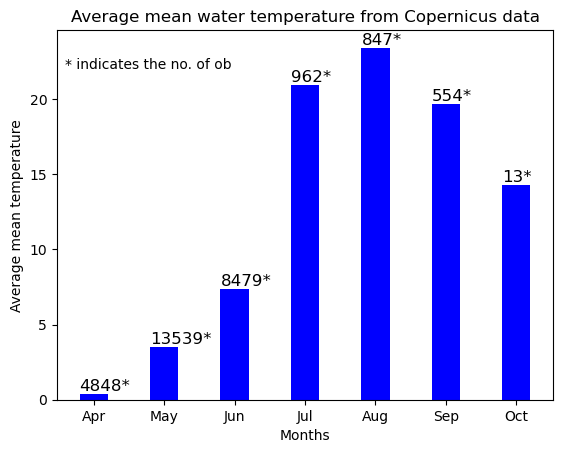

In [40]:
# Calculate average mean temperature from Copernicus data
cop_temp_list = []
ob_num_list = []
for i in range(4, 11):
    monthly_temp =  merged_cop_fish.loc[merged_cop_fish['report_datetime'].dt.month == i].mean_temp.mean()
    cop_temp_list.append(monthly_temp)
    ob_num = len(merged_cop_fish.loc[merged_cop_fish['report_datetime'].dt.month == i].mean_temp)
    ob_num_list.append(ob_num)

# X-axis 
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']     

# Plotting
plt.bar(month, cop_temp_list, color ='blue', width = 0.4)
# plt.legend()
plt.xlabel("Months")
plt.ylabel("Average mean temperature")
plt.title("Average mean water temperature from Copernicus data")
plt.text(-0.4, 22, r'* indicates the no. of ob', fontsize=10)

# Plot num of obs
combined_list = list(zip(ob_num_list, cop_temp_list))
for i, (ob, temp) in enumerate(combined_list):
    plt.text(i-0.2, temp+0.2, f'{ob}*', fontsize=12) 

In [41]:
cop_temp_list

[0.3874069641823742,
 3.510107671565038,
 7.381244712413984,
 20.941916106892226,
 23.425129752751296,
 19.682868287195905,
 14.304840007080482]

##### Points to note: 
* Temperature range from 0.39 to 23.4

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


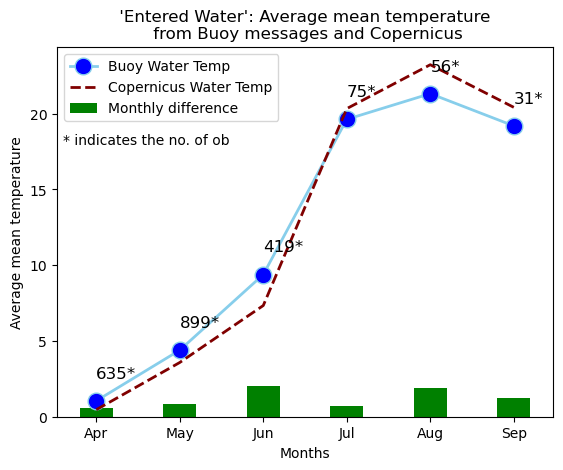

In [31]:
# Plot 'Entered Water': Average mean temperature from Buoy messages and Copernicus

# Select 'Entered Water' only data 
entered_water = merged_cop_fish.loc[merged_cop_fish['system_status_interpret'] == 'Entered Water']

# Calculate average mean temperature from Buoy messages
buoy_temp_list = []
for i in range(4, 11):
    monthly_temp =  entered_water.loc[entered_water['report_datetime'].dt.month == i].water_temperature_mean.mean()
    buoy_temp_list.append(monthly_temp)

# Calculate average mean temperature from Copernicus
cop_temp_list = []
ob_num_list = []
for x in range(4, 11):
    monthly_temp =  entered_water.loc[entered_water['report_datetime'].dt.month == x].mean_temp.mean()
    ob_num = len(entered_water.loc[entered_water['report_datetime'].dt.month == x].mean_temp)
    cop_temp_list.append(monthly_temp)
    ob_num_list.append(ob_num)

# X-axis 
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'] 

# Differences
entered_water_diff = [ abs(e1 - e2) for (e1, e2) in zip(buoy_temp_list, cop_temp_list)]

# Plotting
plt.bar(month, entered_water_diff, color ='green', width = 0.4, label = "Monthly difference")
plt.plot(month, buoy_temp_list, label = "Buoy Water Temp", marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot(month, cop_temp_list, label = "Copernicus Water Temp", marker='', linestyle='dashed', color='maroon', markersize=12, linewidth=2)
plt.legend()
plt.xlabel("Months")
plt.ylabel("Average mean temperature")
plt.title(" 'Entered Water': Average mean temperature \n from Buoy messages and Copernicus")
plt.text(-0.4, 18, r'* indicates the no. of ob', fontsize=10)

# Plot num of obs
combined_list = list(zip(ob_num_list, buoy_temp_list))
for i, (ob, temp) in enumerate(combined_list):
    plt.text(i, temp+1.5, f'{ob}*', fontsize=12)


##### Points to note: 
* There were no Entered/ Left water data in October
* Differences between buoy reported temperatures and Copernicus’ reported temperatures were trivial for "Entered water"
* No patterns found

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


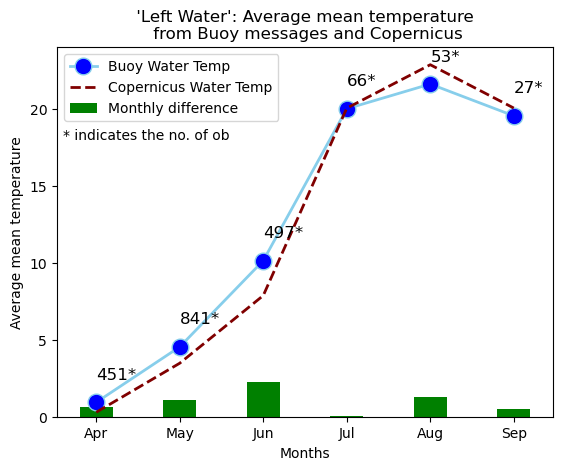

In [32]:
# Plot 'Left Water': Average mean temperature from Buoy messages and Copernicus
# "Left water" deployment had no data in October

# Select 'Entered Water' only data 
left_water = merged_cop_fish.loc[merged_cop_fish['system_status_interpret'] == 'Left Water']

# Calculate average mean temperature from Buoy messages
buoy_temp_list = []
for i in range(4, 11):
    monthly_temp =  left_water.loc[left_water['report_datetime'].dt.month == i].water_temperature_mean.mean()
    buoy_temp_list.append(monthly_temp)

# Calculate average mean temperature from Copernicus
cop_temp_list = []
ob_num_list = []
for x in range(4, 11):
    monthly_temp =  left_water.loc[left_water['report_datetime'].dt.month == x].mean_temp.mean()
    ob_num =  len(left_water.loc[left_water['report_datetime'].dt.month == x].mean_temp)
    cop_temp_list.append(monthly_temp)
    ob_num_list.append(ob_num)
    
# X-axis 
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'] 

# Differences
left_water_diff = [ abs(e1 - e2) for (e1, e2) in zip(buoy_temp_list, cop_temp_list)]

# Plotting
plt.bar(month, left_water_diff, color ='green', width = 0.4, label = "Monthly difference")
plt.plot(month, buoy_temp_list, label = "Buoy Water Temp", marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot(month, cop_temp_list, label = "Copernicus Water Temp", marker='', linestyle='dashed', color='maroon', markersize=12, linewidth=2)
plt.legend()
plt.xlabel("Months")
plt.ylabel("Average mean temperature")
plt.title(" 'Left Water': Average mean temperature \n from Buoy messages and Copernicus")
plt.text(-0.4, 18, r'* indicates the no. of ob', fontsize=10)

# Plot num of obs
combined_list = list(zip(ob_num_list, buoy_temp_list))
for i, (ob, temp) in enumerate(combined_list):
    plt.text(i, temp+1.5, f'{ob}*', fontsize=12)

##### Points to note: 
* There were no Entered/ Left water data in October
* Differences between buoy reported temperatures and Copernicus’ reported temperatures were trivial for "Left water"
* No patterns found

### 8. Analyze Water Temperature differences by fishery

#### There are three fisheries: Maine, Massachusetts, and New Brunswick/Gulf of St. Lawrence

In [29]:
# Check the number of fisheries
merged_cop_fish['fishery_id'].unique()

array([3, 2, 1])

(0.0, 20.0)

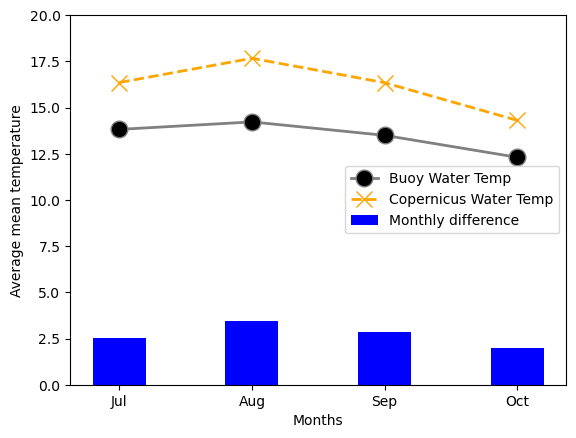

In [32]:
# Fishery 1: Maine
fishery_1 = merged_cop_fish.loc[merged_cop_fish['fishery_id'] == 1]

# Calculate average mean temperature from Buoy messages
buoy_temp_list = []
for i in range(4, 11):
    monthly_temp =  fishery_1.loc[fishery_1['report_datetime'].dt.month == i].water_temperature_mean.mean()
    buoy_temp_list.append(monthly_temp)

# Calculate average mean temperature from Copernicus
cop_temp_list = []
ob_num_list_1 = []
for x in range(4, 11):
    monthly_temp =  fishery_1.loc[fishery_1['report_datetime'].dt.month == x].mean_temp.mean()
    ob_num = len(fishery_1.loc[fishery_1['report_datetime'].dt.month == x].mean_temp)
    cop_temp_list.append(monthly_temp)
    ob_num_list_1.append(ob_num)

# X-axis 
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'] 

# Differences
fishery_1_diff = [ abs(e1 - e2) for (e1, e2) in zip(buoy_temp_list, cop_temp_list)]

# Plotting
plt.bar(month, fishery_1_diff, color ='blue', width = 0.4, label = "Monthly difference")
plt.plot(month, buoy_temp_list, label = "Buoy Water Temp", marker='o', markerfacecolor='black', markersize=12, color='grey', linewidth=2)
plt.plot(month, cop_temp_list, label = "Copernicus Water Temp", marker='x', linestyle='dashed', color='orange', markersize=12, linewidth=2)
plt.legend()
plt.xlabel("Months")
plt.ylabel("Average mean temperature")
plt.ylim([0, 20])
# plt.title(" 'Maine': Average mean temperature from Buoy messages and Copernicus")
# plt.text(5, 7.5, r'* indicates the no. of ob', fontsize=10)

# # Plot num of obs
# combined_list = list(zip(ob_num_list_1, cop_temp_list))
# for i, (ob, temp) in enumerate(combined_list):
#     plt.text(i, temp+0.5, f'{ob}*', fontsize=12)




##### Points to note: 
* For Maine, temperatures from Copernicus data were consistently higher than those from Buoy messages

Text(0, 0.5, 'Average mean temperature')

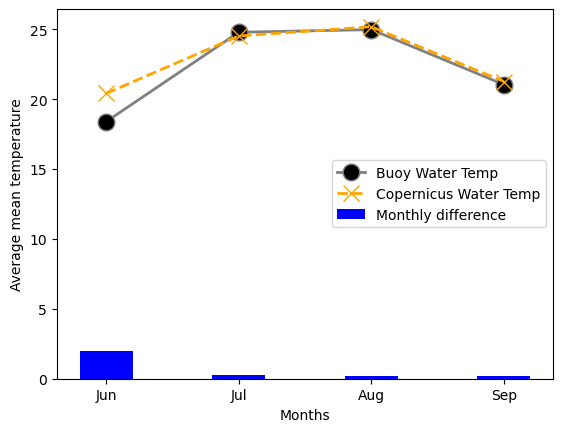

In [33]:
# Fishery 2: Massachusetts
fishery_2 = merged_cop_fish.loc[merged_cop_fish['fishery_id'] == 2]

# Calculate average mean temperature from Buoy messages
buoy_temp_list_2 = []
for i in range(4, 11):
    monthly_temp_2 =  fishery_2.loc[fishery_2['report_datetime'].dt.month == i].water_temperature_mean.mean()
    buoy_temp_list_2.append(monthly_temp_2)

# Calculate average mean temperature from Copernicus
cop_temp_list_2 = []
ob_num_list_2 = []
for x in range(4, 11):
    monthly_temp_2 =  fishery_2.loc[fishery_2['report_datetime'].dt.month == x].mean_temp.mean()
    cop_temp_list_2.append(monthly_temp_2)  
    ob_num = len(fishery_2.loc[fishery_2['report_datetime'].dt.month == x].mean_temp)
    ob_num_list_2.append(ob_num)

    
# X-axis 
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'] 

# Differences
fishery_2_diff = [ abs(e1 - e2) for (e1, e2) in zip(buoy_temp_list_2, cop_temp_list_2)]

# Plotting
plt.bar(month, fishery_2_diff, color ='blue', width = 0.4, label = "Monthly difference")
plt.plot(month, buoy_temp_list_2, label = "Buoy Water Temp", marker='o', markerfacecolor='black', markersize=12, color='grey', linewidth=2)
plt.plot(month, cop_temp_list_2, label = "Copernicus Water Temp", marker='x', linestyle='dashed', color='orange', markersize=12, linewidth=2)
plt.legend(loc = "right")
plt.xlabel("Months")
plt.ylabel("Average mean temperature")
# plt.title(" 'Massachusetts': Average mean temperature from Buoy messages and Copernicus")
# plt.text(4, 9, r'* indicates the no. of ob', fontsize=10)

# Plot num of obs
# combined_list = list(zip(ob_num_list_2, cop_temp_list_2))
# for i, (ob, temp) in enumerate(combined_list):
#     plt.text(i, temp+0.5, f'{ob}*', fontsize=12)


##### Points to note: 
* For Fishery 2, temperatures from Copernicus data were similar to those from Buoy messages

Text(0, 0.5, 'Average mean temperature')

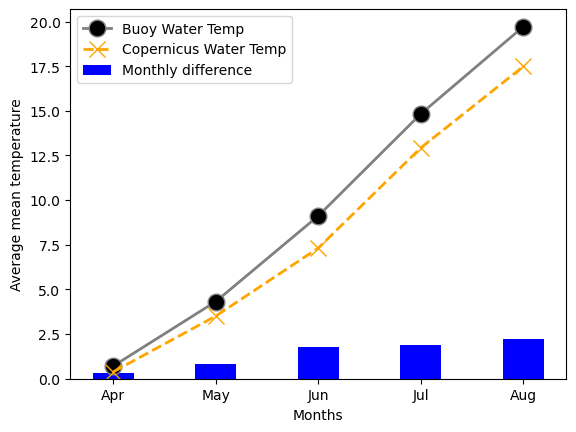

In [34]:
# Fishery 3: New Brunswick/Gulf of St. Lawrence
fishery_3 = merged_cop_fish.loc[merged_cop_fish['fishery_id'] == 3]

# Calculate average mean temperature from Buoy messages
buoy_temp_list_3 = []
for i in range(4, 11):
    monthly_temp_3 =  fishery_3.loc[fishery_3['report_datetime'].dt.month == i].water_temperature_mean.mean()
    buoy_temp_list_3.append(monthly_temp_3)

# Calculate average mean temperature from Copernicus
cop_temp_list_3 = []
ob_num_list_3 = []

for x in range(4, 11):
    monthly_temp_3 =  fishery_3.loc[fishery_3['report_datetime'].dt.month == x].mean_temp.mean()
    cop_temp_list_3.append(monthly_temp_3)  
    ob_num = len(fishery_3.loc[fishery_3['report_datetime'].dt.month == x].mean_temp)
    ob_num_list_3.append(ob_num)
    
# X-axis 
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'] 

# Differences
fishery_3_diff = [ abs(e1 - e2) for (e1, e2) in zip(buoy_temp_list_3, cop_temp_list_3)]

# Plotting
plt.bar(month, fishery_3_diff, color ='blue', width = 0.4, label = "Monthly difference")
plt.plot(month, buoy_temp_list_3, label = "Buoy Water Temp", marker='o', markerfacecolor='black', markersize=12, color='grey', linewidth=2)
plt.plot(month, cop_temp_list_3, label = "Copernicus Water Temp", marker='x', linestyle='dashed', color='orange', markersize=12, linewidth=2)
plt.legend()
plt.xlabel("Months")
plt.ylabel("Average mean temperature")
# plt.title(" 'New Brunswick/Gulf of St. Lawrence': Average mean temperature from Buoy messages and Copernicus")
# plt.text(-0.4, 15.5, r'* indicates the no. of ob', fontsize=10)

# # Plot num of obs
# combined_list = list(zip(ob_num_list_3, buoy_temp_list_3))
# for i, (ob, temp) in enumerate(combined_list):
#     plt.text(i, temp+0.2, f'{ob}*', fontsize=12)


##### Points to note: 
* For Fishery 3, temperatures from Copernicus data were consistently lower than those from Buoy messages

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


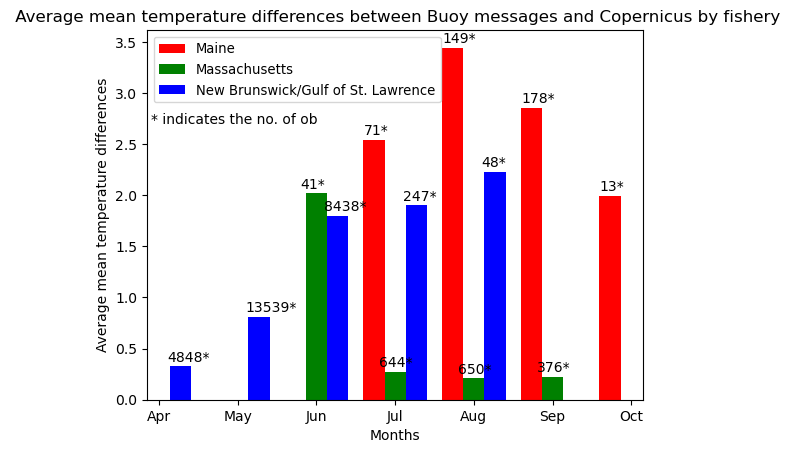

In [482]:
# Temp differences by fisheries
width = 0.27  
fig = plt.figure()
ax = fig.add_subplot(111)
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
X_axis = np.arange(len(month))

# Plotting
rects1 = ax.bar(X_axis-width, fishery_1_diff, width, color='r', label = 'Maine')
rects2 = ax.bar(X_axis, fishery_2_diff, width, color='g', label = 'Massachusetts')
rects3 = ax.bar(X_axis+width, fishery_3_diff, width, color='b', label = 'New Brunswick/Gulf of St. Lawrence')

plt.xticks(X_axis, month)
plt.xlabel("Months")
plt.ylabel("Average mean temperature differences")
plt.title(" Average mean temperature differences between Buoy messages and Copernicus by fishery")
plt.legend(loc='upper left', prop={'size': 9.5})
plt.text(-0.1, 2.7, r'* indicates the no. of ob', fontsize=10)

# Plot num of obs
combined_list_1 = list(zip(ob_num_list_1, fishery_1_diff))
for i, (ob, diff) in enumerate(combined_list_1):
    ax.text(i-0.4, diff + .05, f'{ob}*', color='black')

combined_list_2 = list(zip(ob_num_list_2, fishery_2_diff))
for i, (ob, diff) in enumerate(combined_list_2):
    ax.text(i-0.2, diff + .05, f'{ob}*', color='black')
    
combined_list_3 = list(zip(ob_num_list_3, fishery_3_diff))
for i, (ob, diff) in enumerate(combined_list_3):
    ax.text(i+0.1, diff + .05, f'{ob}*', color='black')


#### Points to note:
* Some fisheries did not have data in certain months
* Overall, Maine had the largest temperature discrepancies between Buoy reported data and Copernicus data 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


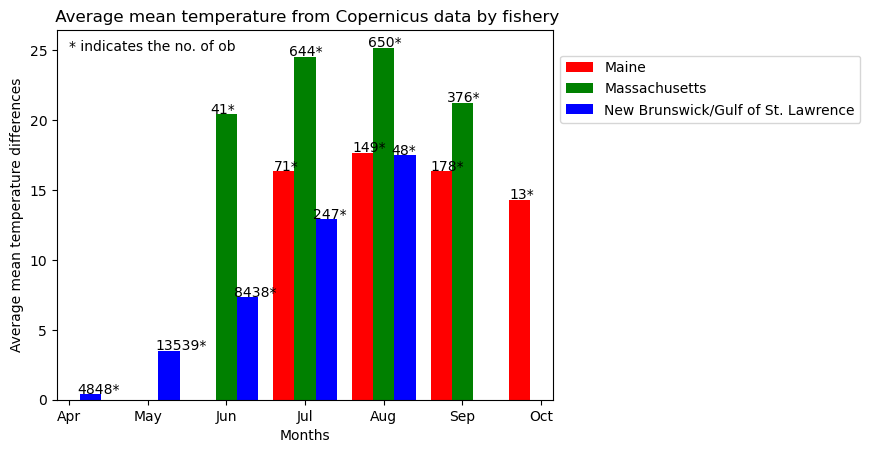

In [383]:
# Temp differences by fisheries
width = 0.27  
fig = plt.figure()
ax = fig.add_subplot(111)
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
X_axis = np.arange(len(month))

# Plotting
rects1 = ax.bar(X_axis-width, cop_temp_list, width, color='r', label = 'Maine')
rects2 = ax.bar(X_axis, cop_temp_list_2, width, color='g', label = 'Massachusetts')
rects3 = ax.bar(X_axis+width, cop_temp_list_3, width, color='b', label = 'New Brunswick/Gulf of St. Lawrence')

plt.legend(bbox_to_anchor=(1, .95))
plt.xticks(X_axis, month)
plt.xlabel("Months")
plt.ylabel("Average mean temperature differences")
plt.title(" Average mean temperature from Copernicus data by fishery")
plt.text(0, 25, r'* indicates the no. of ob', fontsize=10)

# Plot num of obs
combined_list_1 = list(zip(ob_num_list_1, cop_temp_list))
for i, (ob, temp) in enumerate(combined_list_1):
    ax.text(i-0.4, temp + .05, f'{ob}*', color='black')

combined_list_2 = list(zip(ob_num_list_2, cop_temp_list_2))
for i, (ob, temp) in enumerate(combined_list_2):
    ax.text(i-0.2, temp + .05, f'{ob}*', color='black')
    
combined_list_3 = list(zip(ob_num_list_3, cop_temp_list_3))
for i, (ob, temp) in enumerate(combined_list_3):
    ax.text(i+0.1, temp + .05, f'{ob}*', color='black')

#### Points to note:
* Some fisheries did not have data in certain months
* Overall, Massachusetts had the highest average mean temperature according to Copernicus data
* Because of missing data in some months, it is hard to compare Maine and New Brunswick/Gulf of St. Lawrence

### 9. Significance Test

#### This section examines whether there is significant water temp difference among fisheries

In [165]:
merged_cop_fish.head(2)

,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean_temp,median,count,buoy_id,fishery_id,system_status,system_status_int,system_status_cat,system_status_interpret
0,2022-04-13 17:39:46,47.706745,-63.213696,2.0,2.0,POLYGON ((-63.21368289593095 47.70674150844756...,0.05649,0.05649,0.05649,0.05649,1,522,3,1557.0,1557,"[in_water, update_reason_sws, update_reason_sc...",Entered Water
1,2022-04-13 17:40:06,47.704243,-63.216167,1.0,1.0,POLYGON ((-63.21615389634137 47.70423950867799...,0.05649,0.05649,0.05649,0.05649,1,528,3,1557.0,1557,"[in_water, update_reason_sws, update_reason_sc...",Entered Water


In [36]:
# To study the difference between Buoy water temp (water_temperature_mean) and Copernicus temp (mean_temp) is significant by fishery

# Calculate the difference between Buoy water temp (mean) and Copernicus temp (mean)
merged_cop_fish['mean_temp_diff'] = abs(merged_cop_fish['water_temperature_mean'] - merged_cop_fish['mean_temp'])

# Encoding categorical variable
merged_cop_fish = pd.get_dummies(merged_cop_fish, columns=['fishery_id'], drop_first=True)

X = merged_cop_fish[['fishery_id_2', 'fishery_id_3']] 
y = merged_cop_fish['mean_temp_diff']
X = sm.add_constant(X)

model1 = sm.OLS(y, X).fit()

print_model= model1.summary()
print(print_model)



                            OLS Regression Results                            
Dep. Variable:         mean_temp_diff   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     25.13
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.25e-11
Time:                        07:39:27   Log-Likelihood:                -93732.
No. Observations:               29242   AIC:                         1.875e+05
Df Residuals:                   29239   BIC:                         1.875e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.0014      0.294     10.195   

### 10. Outlier exploration

In [37]:
# Describe mean temperature difference
merged_cop_fish['mean_temp_diff'].describe()


count    29242.000000
mean         1.697026
std          5.973525
min          0.000092
25%          0.385876
50%          0.935530
75%          1.812746
max        153.949309
Name: mean_temp_diff, dtype: float64

The max. absolute temperature difference was 153.9! 

In [38]:
# Describe Buoy water temperature difference
merged_cop_fish['water_temperature_mean'].describe()


count    29242.000000
mean         6.499453
std          8.299810
min       -148.000000
25%          2.000000
50%          6.000000
75%          9.000000
max         30.000000
Name: water_temperature_mean, dtype: float64

In [41]:
outlier_subset = merged_cop_fish[['buoy_id','report_datetime', 'latitude', 'longitude', 'water_temperature_mean']]
outlier_subset.loc[outlier_subset['water_temperature_mean'] < -50]

,buoy_id,report_datetime,latitude,longitude,water_temperature_mean
5203,481,2022-05-01 23:01:00,47.411736,-62.588898,-146.0
5621,481,2022-05-02 22:41:20,47.411945,-62.588543,-146.0
5661,481,2022-05-03 00:17:17,47.420850,-62.610760,-146.0
5723,481,2022-05-03 02:20:45,47.421024,-62.610610,-146.0
5926,481,2022-05-03 14:20:36,47.420803,-62.611397,-146.0
6094,481,2022-05-04 02:20:27,47.420727,-62.612663,-146.0
7911,481,2022-05-08 05:41:37,47.420803,-62.610336,-146.0
8335,481,2022-05-09 05:41:25,47.420750,-62.609913,-146.0
8506,481,2022-05-09 17:41:25,47.421143,-62.609524,-146.0
8859,481,2022-05-10 18:41:28,47.421660,-62.609653,-146.0


In [404]:
# Examine one of the outlier buoys
buoy481 = merged_cop_fish.loc[merged_cop_fish['buoy_id'] == 481]
buoy481_deploy = buoy481.loc[(merged_cop_fish['report_datetime'] >= "2022-04-27 20:47:06") & (merged_cop_fish['report_datetime']<= "2022-05-02 22:41:20")]


In [468]:
buoy481_deploy

,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean_temp,median,count,buoy_id,fishery_id,system_status,system_status_int,system_status_cat,system_status_interpret,label
3664,2022-04-27 20:47:06,47.412067,-62.589092,1.0,1.000000e+00,POLYGON ((-62.589078998386135 47.4120634428143...,0.961791,0.961791,0.961791,0.961791,1,481,3,1557.0,1557,"[in_water, update_reason_sws, update_reason_sc...",Entered Water,1.0 481 2022-04-27 20:47:06
3690,2022-04-27 22:50:25,47.412796,-62.588455,1.0,1.000000e+00,POLYGON ((-62.588441998264315 47.4127924427556...,0.970580,0.970580,0.970580,0.970580,1,481,3,1045.0,1045,"[in_water, update_reason_scheduled]",Scheduled,1.0 481 2022-04-27 22:50:25
3853,2022-04-28 10:50:26,47.412510,-62.588146,0.0,1.000000e+00,POLYGON ((-62.588132998345685 47.4125064427220...,0.807978,0.807978,0.807978,0.807978,1,481,3,1045.0,1045,"[in_water, update_reason_scheduled]",Scheduled,0.0 481 2022-04-28 10:50:26
4038,2022-04-28 22:50:36,47.412930,-62.588223,0.0,1.000000e+00,POLYGON ((-62.58820999824881 47.41292644273321...,0.821894,0.821894,0.821894,0.821894,1,481,3,1045.0,1045,"[in_water, update_reason_scheduled]",Scheduled,0.0 481 2022-04-28 22:50:36
4230,2022-04-29 10:50:36,47.412180,-62.588287,0.0,1.175494e-38,"POLYGON ((-62.58827399840972 47.4121764427338,...",0.749382,0.749382,0.749382,0.749382,1,481,3,1045.0,1045,"[in_water, update_reason_scheduled]",Scheduled,0.0 481 2022-04-29 10:50:36
4423,2022-04-29 22:51:47,47.411730,-62.588560,0.0,1.000000e+00,POLYGON ((-62.58854699849214 47.41172644275786...,0.737663,0.737663,0.737663,0.737663,1,481,3,1045.0,1045,"[in_water, update_reason_scheduled]",Scheduled,0.0 481 2022-04-29 22:51:47
4623,2022-04-30 10:51:37,47.412050,-62.588375,0.0,1.175494e-38,POLYGON ((-62.588361998432966 47.4120464427416...,0.678335,0.678335,0.678335,0.678335,1,481,3,1045.0,1045,"[in_water, update_reason_scheduled]",Scheduled,0.0 481 2022-04-30 10:51:37
4829,2022-04-30 22:54:54,47.411774,-62.589250,0.0,1.000000e+00,"POLYGON ((-62.589236998441 47.41177044282806, ...",0.687857,0.687857,0.687857,0.687857,1,481,3,1045.0,1045,"[in_water, update_reason_scheduled]",Scheduled,0.0 481 2022-04-30 22:54:54
4861,2022-05-01 00:55:37,47.411602,-62.589287,0.0,0.000000e+00,POLYGON ((-62.58927399847656 47.41159844283044...,0.681997,0.681997,0.681997,0.681997,1,481,3,50333717.0,50333717,"[in_water, update_reason_moved]",Moved,0.0 481 2022-05-01 00:55:37
5046,2022-05-01 12:58:47,47.411934,-62.588620,0.0,1.175494e-38,POLYGON ((-62.588606998443716 47.4119304427655...,0.680532,0.680532,0.680532,0.680532,1,481,3,16778261.0,16778261,"[in_water, update_reason_scheduled]",Scheduled,0.0 481 2022-05-01 12:58:47


The min. buoy reported temperature was -148!

In [466]:
# Plot the outlier buoy measurements with bounding box
def map_buoy_temp(buoys_df):
    s = buoy481_deploy
    s['label'] = s.apply(lambda r: str(r['water_temperature_mean']) + " " + str(r['buoy_id']) + " " + str(r['report_datetime']), axis='columns')
    fig = go.Figure(go.Scattermapbox(
      mode = "markers",
      lon = s['longitude'],
      lat = s['latitude'],
      marker_color=s['water_temperature_mean'],
      marker={'showscale': True},
      hovertext=s['label']))

    fig.update_layout(
      margin ={'l':0,'t':0,'b':0,'r':0},
      mapbox = {
          'center': {'lon': -62, 'lat': 47},
          'style': "stamen-terrain",
          'center': {'lon': -62.5, 'lat': 47.4},
          'zoom': 8})

    fig.show()

/tmp/ipykernel_85/140559461.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



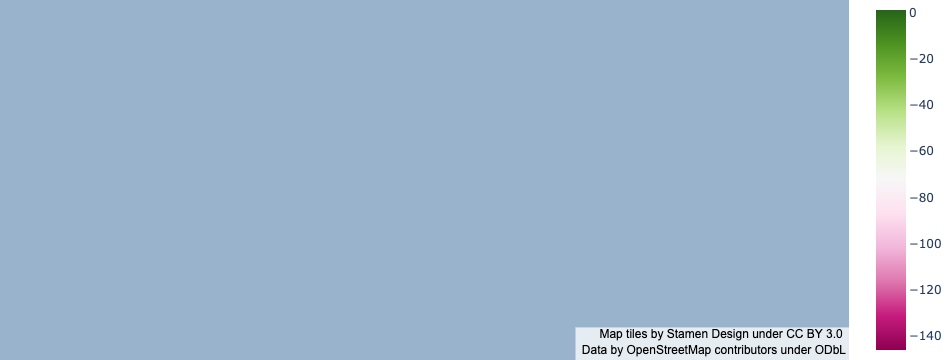

In [467]:
map_buoy_temp(buoy481_deploy)

Text(0.5, 1.0, "Outliner buoy's temperature across time \n (from entered water until left water)")

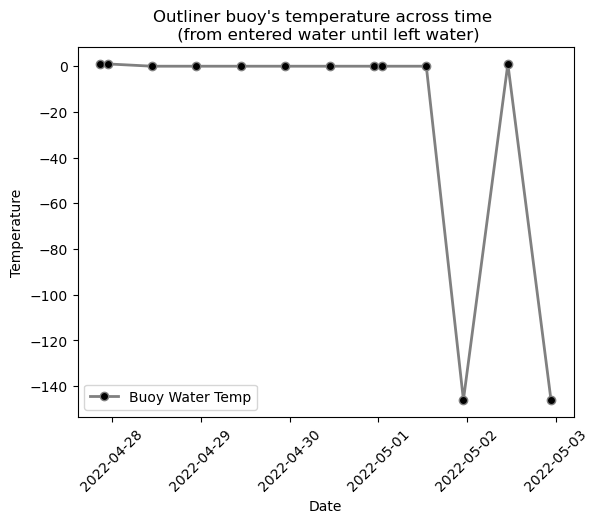

In [480]:
# Examine an Outlier: buoy 481

# Plotting water temp in one deployment
plt.plot(buoy481_deploy.report_datetime, buoy481_deploy.water_temperature_mean, label = "Buoy Water Temp", marker='.', markerfacecolor='black', markersize=12, color='grey', linewidth=2)

plt.legend()

plt.xlabel("Date")
plt.xticks(rotation = 45)
plt.ylabel("Temperature")
plt.title("Outliner buoy's temperature across time \n (from entered water until left water)")




In [169]:
# Abnormal temperature difference (i.e. differences greater than 50) 
merged_cop_fish.loc[merged_cop_fish['mean_temp_diff'] >= 50].head()


,report_datetime,latitude,longitude,water_temperature_mean,water_temperature_q3,geometry,min,max,mean_temp,median,count,buoy_id,system_status,system_status_int,system_status_cat,system_status_interpret,mean_temp_diff,fishery_id_2,fishery_id_3
5203,2022-05-01 23:01:00,47.411736,-62.588898,-146.0,1.000000e+00,POLYGON ((-62.588884998470505 47.4117324427921...,0.701041,0.701041,0.701041,0.701041,1,481,16778517.0,16778517,"[in_water, update_reason_resurfaced, update_re...",Resurfaced,146.701041,0,1
5621,2022-05-02 22:41:20,47.411945,-62.588543,-146.0,1.000000e+00,POLYGON ((-62.58852999844593 47.41194144275783...,1.078249,1.078249,1.078249,1.078249,1,481,16777744.0,16777744,[update_reason_sws],Left Water,147.078249,0,1
5661,2022-05-03 00:17:17,47.420850,-62.610760,-146.0,1.175494e-38,POLYGON ((-62.61074699515485 47.42084644507653...,1.061403,1.061403,1.061403,1.061403,1,481,16778773.0,16778773,"[in_water, update_reason_sws, update_reason_sc...",Entered Water,147.061403,0,1
5723,2022-05-03 02:20:45,47.421024,-62.610610,-146.0,1.175494e-38,POLYGON ((-62.610596995125626 47.4210204450627...,1.016724,1.016724,1.016724,1.016724,1,481,16778261.0,16778261,"[in_water, update_reason_scheduled]",Scheduled,147.016724,0,1
5926,2022-05-03 14:20:36,47.420803,-62.611397,-146.0,1.175494e-38,POLYGON ((-62.611383995126936 47.4207994451406...,1.038697,1.038697,1.038697,1.038697,1,481,16778261.0,16778261,"[in_water, update_reason_scheduled]",Scheduled,147.038697,0,1


In [170]:
# Drop "bad" buoy data (i.e., water_temperature_mean <= -30)
merged_cop_fish_2 = merged_cop_fish.loc[merged_cop_fish['water_temperature_mean'] > -30]
merged_cop_fish_2['mean_temp_diff'].describe()

count    29200.000000
mean         1.483591
std          2.002900
min          0.000092
25%          0.385510
50%          0.934080
75%          1.807024
max         25.428083
Name: mean_temp_diff, dtype: float64

After dropping buoy messages with less than -30 degree Celsius, the differences between buoy reported temperatures and Copernicus’ reported temperatures were not very significant.